In [1]:
!wget https://raw.githubusercontent.com/mhulden/eztransformer/refs/heads/main/eztr.py
!mkdir downloads
!mv eztr.py downloads
## to clean up: rm downloads/eztr.py

%pip install -r "../requirements.txt"
device = "cuda"

--2026-01-02 17:51:29--  https://raw.githubusercontent.com/mhulden/eztransformer/refs/heads/main/eztr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17140 (17K) [text/plain]
Saving to: ‘eztr.py’

eztr.py             100%[===================>]  16.74K  --.-KB/s    in 0s      

2026-01-02 17:51:29 (101 MB/s) - ‘eztr.py’ saved [17140/17140]

mkdir: cannot create directory ‘downloads’: File exists
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [2]:
import matplotlib.pyplot as plt
from typing import Literal
from datasets import load_dataset
from downloads.eztr import EZTransformer

In [33]:
# Load the default data ########################################################

def load_data(
    lang: Literal['egyptian', 'gulf'],
    split: Literal['all', 'train', 'dev', 'no'] = 'all',
):
    lang = {'egyptian': 'arz', 'gulf': 'afb'}[lang]
    prefix = f"/content/data/{lang}/{lang}"
    files = {}
    if split in {"train", "all"}:
        files["train"] = f"{prefix}.trn"

    if split in {"train", "dev", "all", "no"}:
        files["dev"] = f"{prefix}.dev"

    if split in {"test", "all"}:
        files["test"] = f"{prefix}.tst"

    ds = load_dataset(
        'csv', delimiter="\t", data_files=files,
        column_names=["lemma", "features", "form"])

    if split == "no":
        return ds["dev"]

    return ds

# Aux function #################################################################

def process_split(split_data, batch_size: int = 100, num_proc: int = 4):
    # turn to characters
    split_data = split_data.map(
        lambda batch: {
            "lemma": [list(s) for s in batch["lemma"]],
            "form": [list(t) for t in batch["form"]],
            "features": [f.split(';') for f in batch["features"]],
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
    )

    split_data = split_data.map(
        lambda batch: {
            'src': [l+f for l, f in zip(batch["lemma"], batch["features"])]
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
        remove_columns=['features', 'lemma']
    )

    # only for compatibility with eztransformer's build_vocab
    split_data = split_data.map(
        lambda batch: {
            'src': [' '.join(item) for item in batch['src']],
            'form': [' '.join(item) for item in batch['form']],
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
    )
    return split_data

# Custom data loading ##########################################################

def load_partial(train_size: int,
                 dev_size: int,
                 test_size: int, # This test split is NOT being used downstream for now, but I am keeping it here for consistency
                 batch_size: int,
                 num_proc: int = 4,
                 lang='egyptian'):

    full_data_splits = load_data(lang=lang, split='all')

    processed_data = {}

    processed_data['train'] = full_data_splits['train'].select(range(0, train_size))

    processed_data['dev'] = full_data_splits['dev'].select(range(0, dev_size))

    processed_data['test'] = full_data_splits['test'].select(range(0, test_size))

    for split_name, split_dataset in processed_data.items():
      processed_data[split_name] = process_split(split_dataset, batch_size, num_proc)

    return processed_data

# Get a new model ##############################################################

def get_new_model():
  return EZTransformer(
    device = device,
    # learning rate
    lrt = 1e-3,
    # batch size
    bts = 256,
    # embedding
    eed = 256,
    ded = 256,
    # hidden size:
    ehs = 512,
    dhs = 512,
    # layers:
    enl = 2,
    dnl = 2,
    # heads:
    eah = 4,
    dah = 4,

    save_best = 10,

    # dropout
    drp=0.1
    )

# Model training ###############################################################

def ez_train(model, train_data, valid_data, print_validation_examples = 0):
    if not isinstance(train_data, list):
        train_data = list(zip(train_data["src"], train_data["form"]))
        valid_data = list(zip(valid_data["src"], valid_data["form"]))

    # Train model
    history = model.fit(
        train_data = train_data,
        valid_data = valid_data,
        print_validation_examples = 0,
        max_epochs = 100,
        return_history=True
        )

    model.print_validation_examples(valid_data, print_validation_examples)

    return history

# History analysis #############################################################

def training_history(history):

  min_epoch = history.loc[history["val_loss"].idxmin(), "epoch"]
  text = f"The lowest dev loss was reached in epoch {min_epoch}."

  plt.figure()
  plt.plot(history["epoch"], history["train_loss"], label="Train loss")
  plt.plot(history["epoch"], history["val_loss"], label="Dev loss")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Dev loss")
  plt.legend()

  plt.text(
    60, 0.01,
    text,
    va="bottom",
    fontsize=7,
    color="gray"
)

  plt.show()


# Model testing ################################################################
def test_model(model, language):
  # Preprocess the data
  raw_test_data = load_data(lang=language, split="test")
  processed_test_data = process_split(raw_test_data["test"])

  test_inputs = processed_test_data["src"]
  test_targets = processed_test_data["form"]

  test_examples_for_printing = list(zip(processed_test_data['src'], processed_test_data['form']))

  # Use the default EZTF evaluation method
  model.score(test_inputs, test_targets)

  # Show examples
  model.print_validation_examples(test_examples_for_printing, 3)

In [4]:
data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

In [5]:
%%capture captured_output

egyptian1k = get_new_model()

history = ez_train(egyptian1k, data['train'],
                   data['dev'])

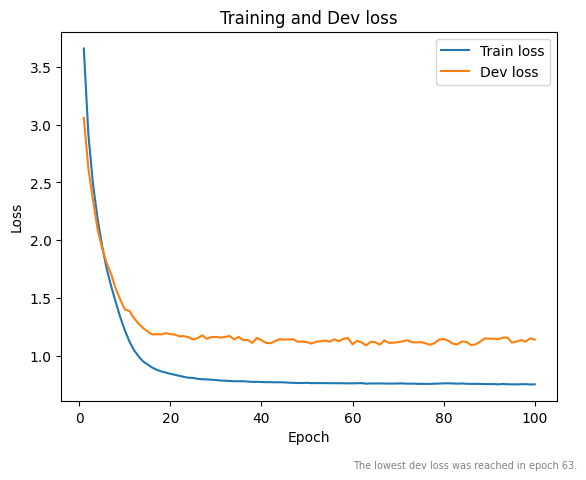

In [34]:
training_history(history)

In [9]:
test_model(egyptian1k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:38<00:00,  2.43s/it]

Accuracy: 7.10%
Average Levenshtein Distance: 3.05

Validation Examples:
Input:     ا ِ ت ْ ج َ س ّ ِ س V IPFV NOM(PL,1)
Target:    ن ِ ت ْ ج َ س ّ ِ س
Predicted: ن ِ ت ْ ج َ س ّ ِ س

Input:     ا ِ ت ْ خ َ ل ّ َ ص V IPFV NOM(PL,1)
Target:    ن ِ ت ْ خ َ ل ّ َ ص
Predicted: ن ِ ت ْ خ َ ل ّ َ ى

Input:     غ ِ ل ِ ط V PFV NOM(FEM,SG,2)
Target:    غ ِ ل ِ ط ت ِ ي
Predicted: آ ل ِ ي ط ِ ي

